In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
from util import *

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
                                       
torch.manual_seed(43)
val_size = 5000
train_size = len(trainset) - val_size
trainset, validationset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                          shuffle = True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def update_layers(self, new_layers):
        for i, new_layer in enumerate(new_layers):
            if hasattr(self, f'fc{i + 1}'):
                setattr(self, f'fc{i + 1}', new_layer)   

In [4]:
def train_cnn_early_stopping(net, criterion, optimizer, trainloader, validationloader, testloader, patience=3, max_epochs=20):
    best_val_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

        # Validate the model on the validation set
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validationloader:
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(validationloader)
        print(f'Validation Loss: {val_loss}')

        # Check for improvement in validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
            best_net = net.state_dict()
        else:
            no_improvement += 1

        # Early stopping check
        if no_improvement >= patience:
            print(f'Early stopping after {epoch + 1} epochs. Best Validation Loss: {best_val_loss}')
            break
    # Load the best model
    net.load_state_dict(best_net)
    return epoch + 1    

In [5]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    return 100 * correct / total

In [6]:
number_of_iterations = 3
pruning_rate = np.linspace(0,0.8, 5)
epochs = np.zeros((len(pruning_rate), number_of_iterations))
test_accuracies = np.zeros((len(pruning_rate), number_of_iterations))

# Including multiple runs with separate initializations and random seeds.
for i in range(number_of_iterations):
    randomseed =  np.random.randint(0, 100)
    torch.manual_seed(randomseed)
    
    # Train the model with early stopping
    input_size = 400
    output_size = 10
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    train_cnn_early_stopping(net, criterion, optimizer, trainloader, validationloader, testloader, patience=3, max_epochs=20)
    
    for p in range(len(pruning_rate)):
        model = copy.deepcopy(net)
        unpruned_layers = oneshot_pruning(model, input_size, output_size, pruning_rate[p])
        model.update_layers(unpruned_layers)
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        epochs[p, i] = train_cnn_early_stopping(model, criterion, optimizer, trainloader, validationloader, testloader, patience=3, max_epochs=20)
        PATH = f'./cifar10_models/pm_{pruning_rate[p]}_rs_{randomseed}_cifar_net.pth'
        torch.save(model.state_dict(), PATH)
        test_accuracies[p, i] = test_model(model, testloader)


[1,  2000] loss: 2.232
[1,  4000] loss: 1.876
[1,  6000] loss: 1.654
[1,  8000] loss: 1.564
[1, 10000] loss: 1.500
Validation Loss: 1.4464678631067276
[2,  2000] loss: 1.385
[2,  4000] loss: 1.387
[2,  6000] loss: 1.340
[2,  8000] loss: 1.317
[2, 10000] loss: 1.291
Validation Loss: 1.3119332597494124
[3,  2000] loss: 1.221
[3,  4000] loss: 1.203
[3,  6000] loss: 1.200
[3,  8000] loss: 1.182
[3, 10000] loss: 1.208
Validation Loss: 1.2171290902256966
[4,  2000] loss: 1.109
[4,  4000] loss: 1.124
[4,  6000] loss: 1.109
[4,  8000] loss: 1.090
[4, 10000] loss: 1.110
Validation Loss: 1.1889418844789266
[5,  2000] loss: 1.027
[5,  4000] loss: 1.034
[5,  6000] loss: 1.044
[5,  8000] loss: 1.049
[5, 10000] loss: 1.031
Validation Loss: 1.1177060072124005
[6,  2000] loss: 0.952
[6,  4000] loss: 0.963
[6,  6000] loss: 0.986
[6,  8000] loss: 0.984
[6, 10000] loss: 0.992
Validation Loss: 1.076771675299853
[7,  2000] loss: 0.905
[7,  4000] loss: 0.920
[7,  6000] loss: 0.934
[7,  8000] loss: 0.948
[7,

[[ 5.  4.  4.]
 [ 5.  4.  5.]
 [ 5.  5.  4.]
 [ 8.  4.  4.]
 [ 4. 10. 11.]]


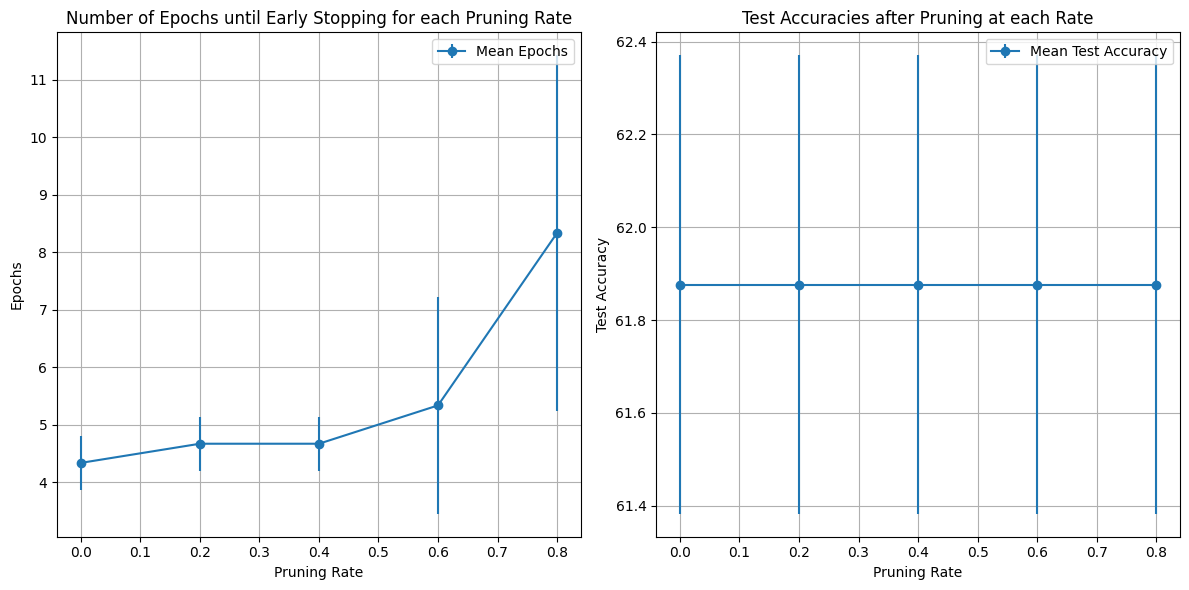

In [7]:
# Plot the performance on train and validation datasets
plt.figure(figsize=(12, 6))
print(epochs)
# Plot the number of epochs until early stopping for each pruning rate with error bars
plt.subplot(1, 2, 1)
epochs_mean = epochs.mean(axis=1)
epochs_std = epochs.std(axis=1)
plt.errorbar(pruning_rate, epochs_mean, yerr=epochs_std, marker='o', label='Mean Epochs')
plt.title('Number of Epochs until Early Stopping for each Pruning Rate')
plt.xlabel('Pruning Rate')
plt.ylabel('Epochs')
plt.legend()
plt.grid(True)

# Plot the test accuracies after pruning at each rate with error bars
plt.subplot(1, 2, 2)
test_accuracies_mean = test_accuracies.mean(axis=1)
test_accuracies_std = test_accuracies.std(axis=1)
plt.errorbar(pruning_rate, test_accuracies_mean, yerr=test_accuracies_std, marker='o', label='Mean Test Accuracy')
plt.title('Test Accuracies after Pruning at each Rate')
plt.xlabel('Pruning Rate')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
def calculate_ece(model, test_loader, title=None, num_bins=10):
    bin_boundaries = np.linspace(0, 1, num_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    predicted_labels = []
    true_labels = []
    confidences = []
    reliabilities = []
    frequency = []

    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            output = F.softmax(output, dim=1)
            class_probabilities = output[:, 0]  # Extract probabilities for the 0th class
            
            _, predicted = torch.max(output.data, 1)
            predicted_labels.append(predicted)
            true_labels.append(target)
            confidences.append(class_probabilities)
    
    predicted_labels = torch.cat(predicted_labels).numpy()
    true_labels = torch.cat(true_labels).numpy()
    confidences = torch.cat(confidences).numpy()

    # get a boolean list of correct/false predictions
    accuracies = predicted_labels==true_labels   

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        prop_in_bin = in_bin.astype(float).mean()
        frequency.append(np.sum(in_bin))    
             
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].astype(float).mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            bin_accuracy = np.mean(true_labels[in_bin]==predicted_labels[in_bin])
            reliabilities.append(bin_accuracy)
        else:
            reliabilities.append(0.0)  # Avoid division by zero

    return ece, frequency, reliabilities

In [20]:
def ece_plot(frequency, reliabilities,ece, num_bins=10):
    bin_edges = np.linspace(0.0, 1.0, num_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot Frequency on the primary y-axis
    ax1.bar(bin_centers, frequency, width=0.05, color='r', label='Frequency')
    ax1.set_xlabel('Confidence')
    ax1.set_ylabel('Frequency', color='r')
    ax1.tick_params('y', colors='r')
    
    # Create a secondary y-axis for Reliability
    ax2 = ax1.twinx()
    ax2.plot(bin_centers, reliabilities, linestyle='--', label='Reliability', color='b')

    ax2.plot(bin_centers, bin_centers, linestyle='-', label='y=x', color='g')
    ax2.set_ylabel('Reliability', color='b')
    ax2.tick_params('y', colors='b')

    plt.title(f'ECE: {ece:.4f}')
    plt.show()

/var/folders/3s/x580703s7yggrlnnlw4jxthr0000gp/T/ipykernel_27608/3650256491.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ece[p][i], freq, reliab = calculate_ece(model,testloader, title = 'testing')


ECE plot for pruning rate:  0.0


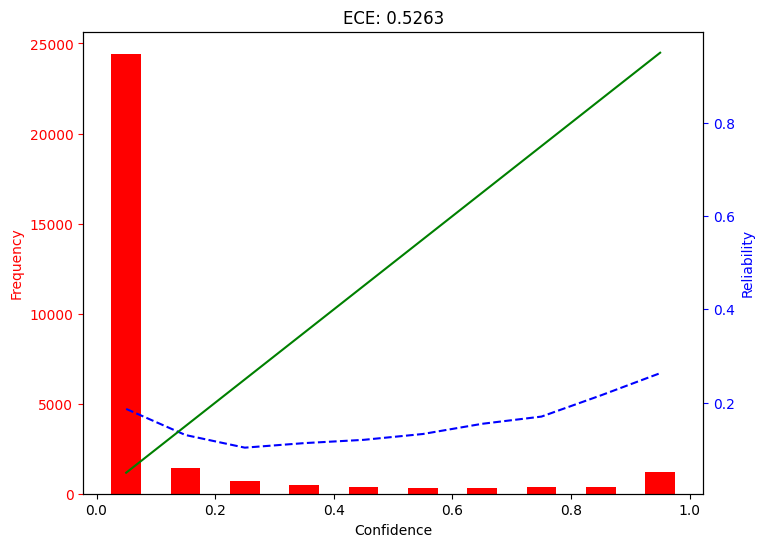

ECE plot for pruning rate:  0.2


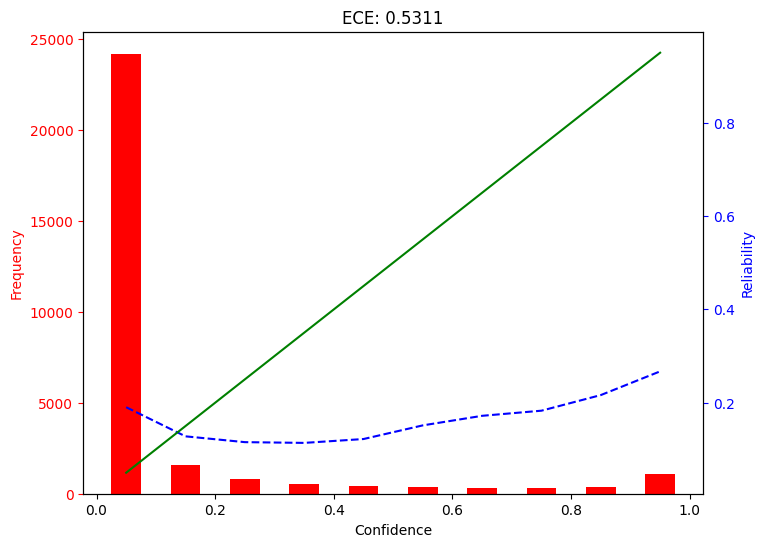

ECE plot for pruning rate:  0.4


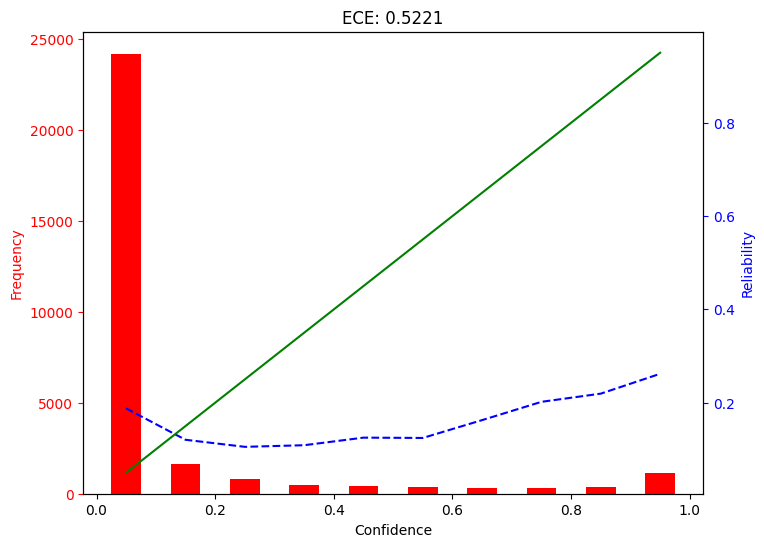

ECE plot for pruning rate:  0.6


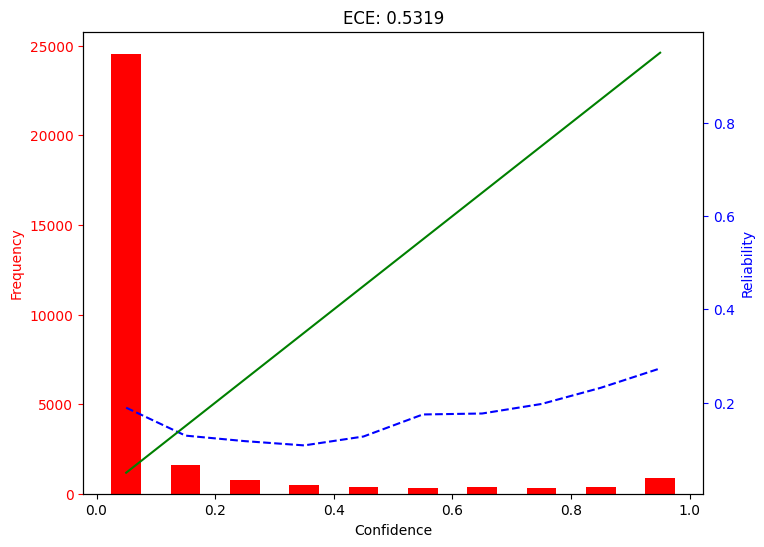

ECE plot for pruning rate:  0.8


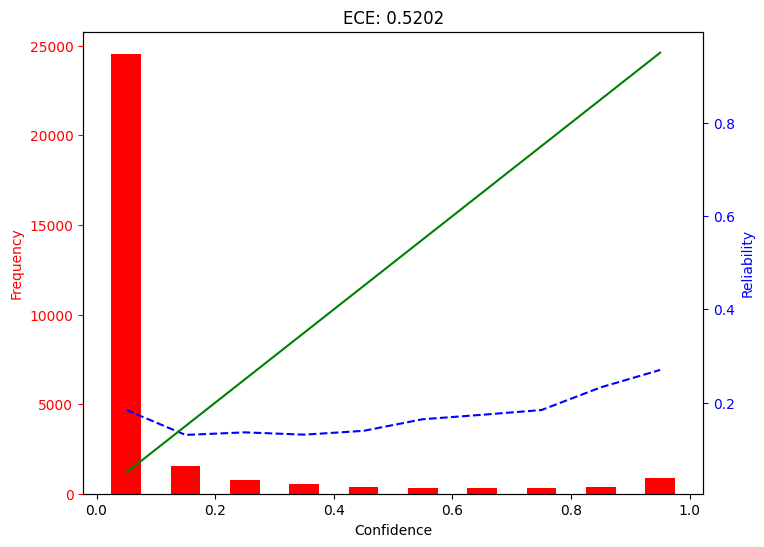

In [21]:
number_of_iterations = 3
pruning_rate = [0.0,0.2,0.4,0.6,0.8]
randomseed =  [11,76,90]
epochs = np.zeros((len(pruning_rate), number_of_iterations))
test_accuracies = np.zeros((len(pruning_rate), number_of_iterations))
ece = np.zeros((len(pruning_rate), number_of_iterations))
frequency = [ [] for _ in range(len(pruning_rate)) ]
reliabilities = [ [] for _ in range(len(pruning_rate)) ]
input_size = 400
output_size = 10

# Including multiple runs with separate initializations and random seeds.
for i in range(len(randomseed)):
    for p in range(len(pruning_rate)):
        model = Net()
        unpruned_layers = oneshot_pruning(model, input_size, output_size, pruning_rate[p])
        model.update_layers(unpruned_layers)
        PATH = f'./cifar10_models/pm_{pruning_rate[p]}_rs_{randomseed[i]}_cifar_net.pth'
        model.load_state_dict(torch.load(PATH))
        ece[p][i], freq, reliab = calculate_ece(model,testloader, title = 'testing')
        frequency[p].append(freq)
        reliabilities[p].append(reliab)
ece = np.mean(ece, axis=1)
frequency = np.sum(frequency, axis=1)
reliabilities = np.sum(reliabilities, axis=1)
for p in range(len(pruning_rate)):    
# Taking the average of the runs for each pruning rate
    print("ECE plot for pruning rate: ", pruning_rate[p])
    ece_plot(frequency[p], reliabilities[p]/10, ece[p], num_bins=10)